### Study of the bursting dynamcis of the nodes

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
from   GDa.session           import session_info, session
from   GDa.spectral_analysis import filtering, time_frequency
from   GDa.misc.create_grids import create_stages_time_grid
from   GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch
import numpy             as np
import matplotlib.pyplot as plt
import scipy
from   tqdm              import tqdm

#### Define stage and band names

In [2]:
stages      = ['baseline', 'cue', 'delay', 'match']
band_names  = [r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$ ', r'high-$\gamma$' ]

In [3]:
# Auxiliary function to smooth
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

#### Phase locking value

In [4]:
def phase_locking_value(x, y):
    h1 = scipy.signal.hilbert(x)
    h2 = scipy.signal.hilbert(y)
    theta1 = np.unwrap(np.angle(h1))
    theta2 = np.unwrap(np.angle(h2))
    complex_phase_diff = np.exp(np.complex(0,1)*(theta1 - theta2))
    PLV = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return PLV

#### Find activation sequences, their length, std and CV

In [5]:
def find_activation_sequences(spike_train):
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], spike_train, [0]))
    # get 1 at run starts and -1 at run ends
    difs    = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends,   = np.where(difs < 0)
    act_lengths =  run_ends - run_starts  # Length of each activation sequence
    return act_lengths
    
def count_activations(spike_train):
    act_lengths = find_activation_sequences(spike_train)
    mu, sigma   = act_lengths.mean(), act_lengths.std()
    return mu, sigma, sigma/mu 

### Instantiating session object

In [6]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', trial_type = 1, \
              behavioral_response = 1, evt_dt = [-0.80, 3.00])
# Read data from .mat files
ses.read_from_mat()

In [7]:
# Defining frequencies
delta = [4,8]
alpha = [8,16]
beta  = [16,40] 
low_gamma  = [40, 70]  
high_gamma = [70, 150]
bands      = [delta, alpha, beta, low_gamma, high_gamma]
freqs = np.arange(4,150,1)

# Morlet
W = time_frequency.wavelet_transform(data = ses.data, baseline_correction = False, 
                                     fs = ses.readinfo['fsample'], freqs = freqs, n_cycles = freqs/2,
                                     time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:  1.3min remaining:   49.8s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:  1.5min remaining:   19.9s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:  1.6min finished


In [8]:
tarray = ses.readinfo['tarray'][::15][20:-20]
print(tarray.shape)

(214,)


In [9]:
W.shape

(540, 49, 146, 254)

In [10]:
### Power spectra
S = ( W[:,:,:,20:-20] * np.conj(W[:,:,:,20:-20]) ).real

In [11]:
S.shape

(540, 49, 146, 214)

In [12]:
S_avg = np.zeros([S.shape[0], S.shape[1], len(bands), S.shape[3]])
# Averaging over bands
for i in tqdm( range(len(bands)) ):
    band = bands[i]
    fidx = (freqs>=band[0])*(freqs<band[1])
    S_avg[:,:,i,:] = S[:,:,fidx,:].mean(axis=2)

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


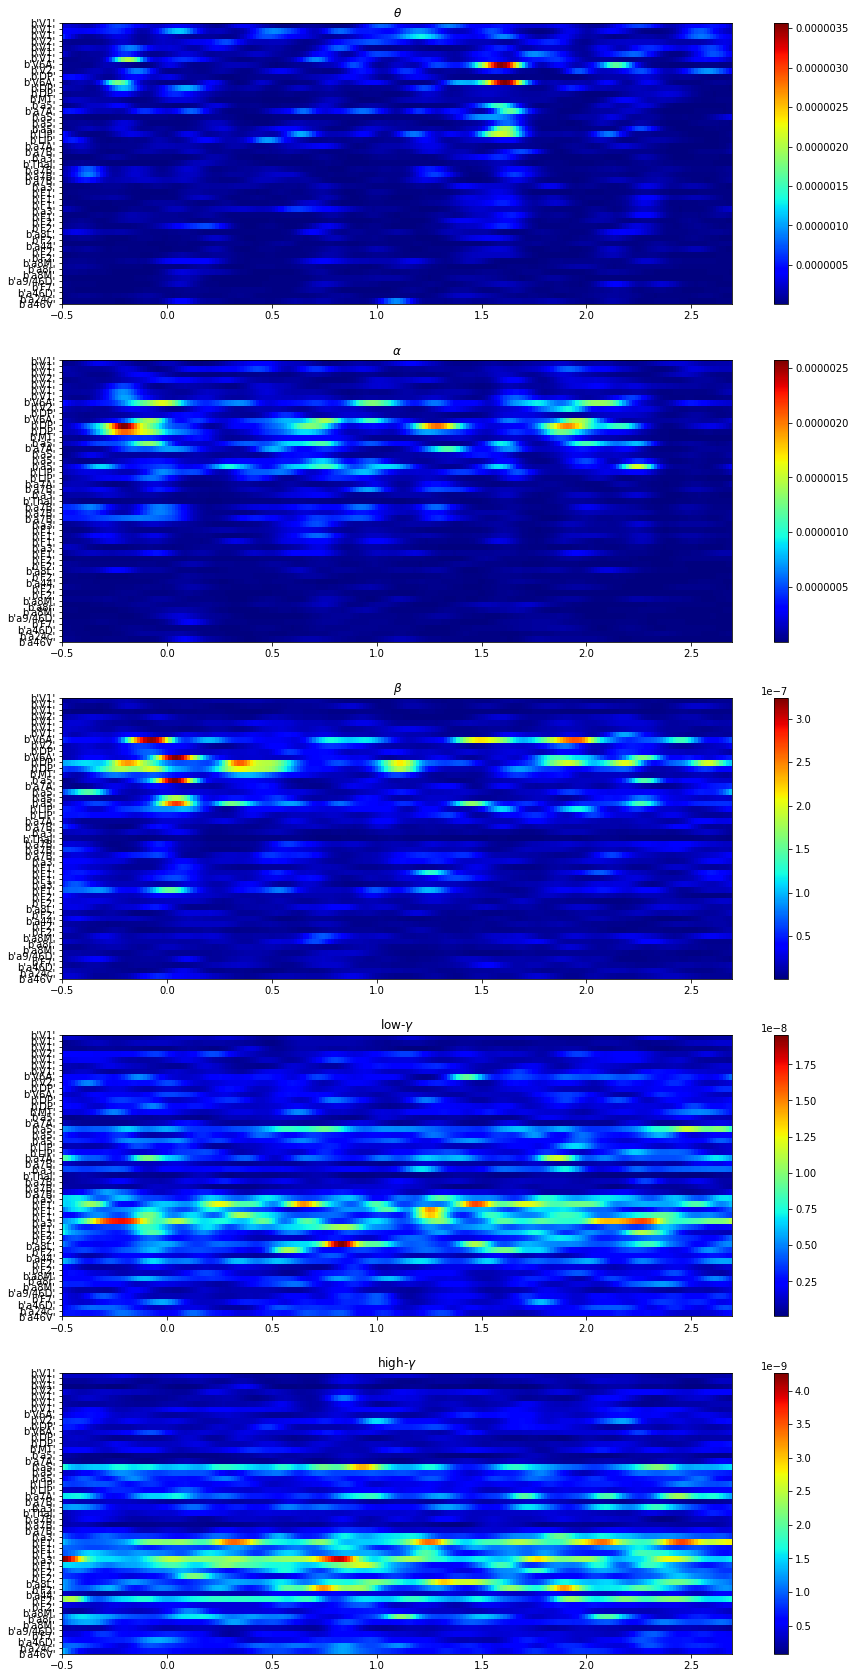

In [13]:
plt.figure(figsize=(15,30))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(S_avg[0,:,i,:],aspect='auto',cmap='jet',origin='lower', 
               extent=[tarray[0],tarray[-1],0,48])
    plt.title(band_names[i])
    plt.yticks(range(49), ses.readinfo['areas'])
    plt.colorbar()

#### Mask to track stages

In [14]:
t_mask = create_stages_time_grid(ses.readinfo['t_cue_on'], ses.readinfo['t_cue_off'], ses.readinfo['t_match_on'], 
                                 ses.readinfo['fsample'], tarray, ses.readinfo['nT'])

In [15]:
St = S_avg.swapaxes(0,2).reshape(49, 5, 540*214)

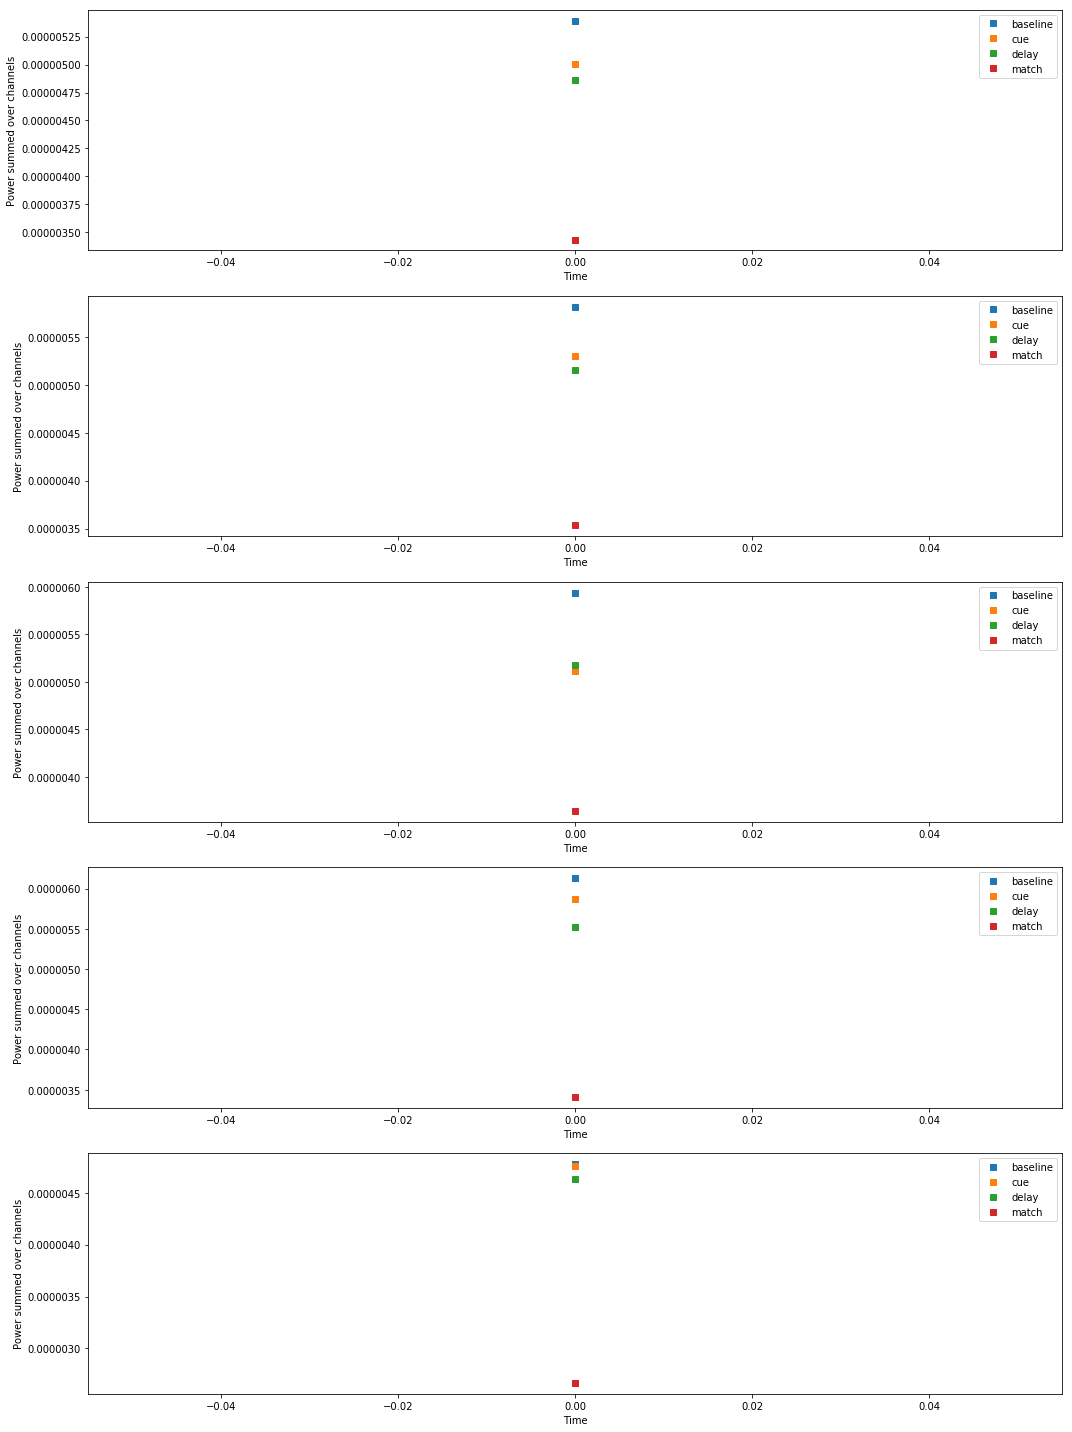

In [35]:
plt.figure(figsize=(15,20))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    for s in range(len(stages)):
        plt.plot( St[:,i,t_mask[s]].mean(axis=-1).sum(axis=0), 's', label = stages[s] )
        plt.ylabel('Power summed over channels')
        plt.xlabel('Time')
        plt.legend()
plt.tight_layout()

In [18]:
raster = np.zeros_like(S_avg)
for i in tqdm( range(len(bands)) ):
    for T in range(ses.readinfo['nT']):
        thr = scipy.stats.mstats.mquantiles(S_avg[T,:,i,:], prob=.95, axis=-1)
        raster[T,:,i,:]= S_avg[T,:,i,:]>thr

100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


100%|██████████| 5/5 [00:00<00:00, 11.15it/s]


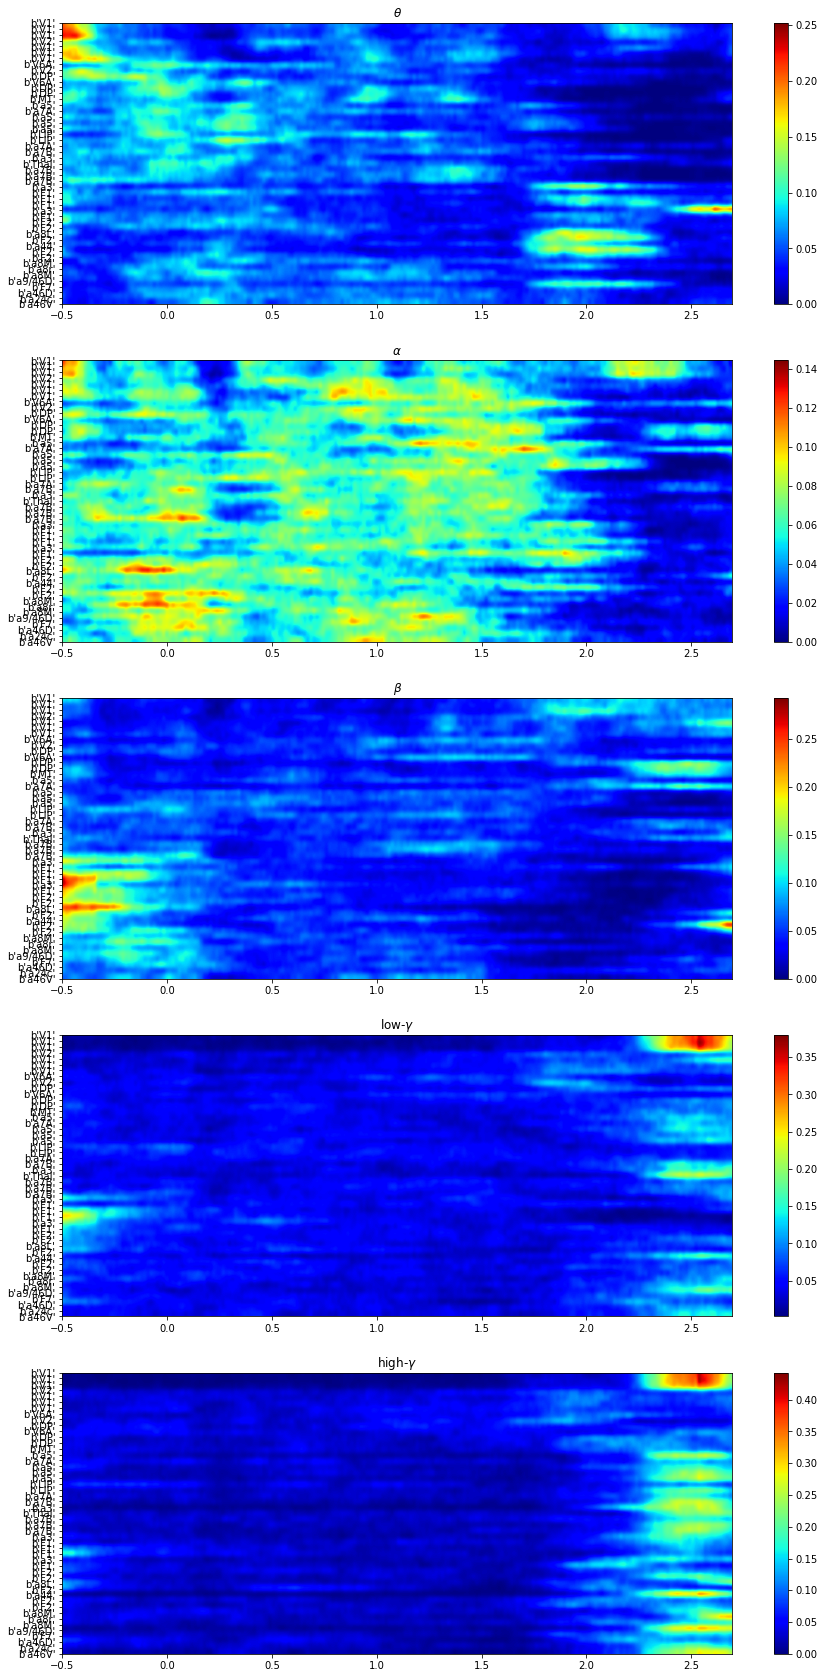

In [19]:
plt.figure(figsize=(15,30))
for i in tqdm( range(len(bands)) ):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(raster[:,:,i,:].mean(axis=0), aspect='auto',cmap='jet', origin='lower',
               extent=[tarray[0],tarray[-1],0,48], interpolation = 'gaussian')
    plt.colorbar()
    plt.yticks(range(49), ses.readinfo['areas'])
    plt.title(band_names[i])

### Distribution of power in each DRT stage

In [29]:
S_avg.shape

(540, 49, 5, 214)

In [33]:
S_ps = np.zeros([len(stages), S_avg.shape[0], S_avg.shape[1], len(bands)])
for i in tqdm( range(S_avg.shape[0]) ):
    for j in range(len(bands)):
        for s in range(len(stages)):
            idx  = t_mask[s].reshape(ses.readinfo['nT'], len(tarray))[i,:]
            S_ps[s,i,:,j] = S_avg[i,:,j,idx].mean(axis=0)

100%|██████████| 540/540 [00:00<00:00, 1067.78it/s]


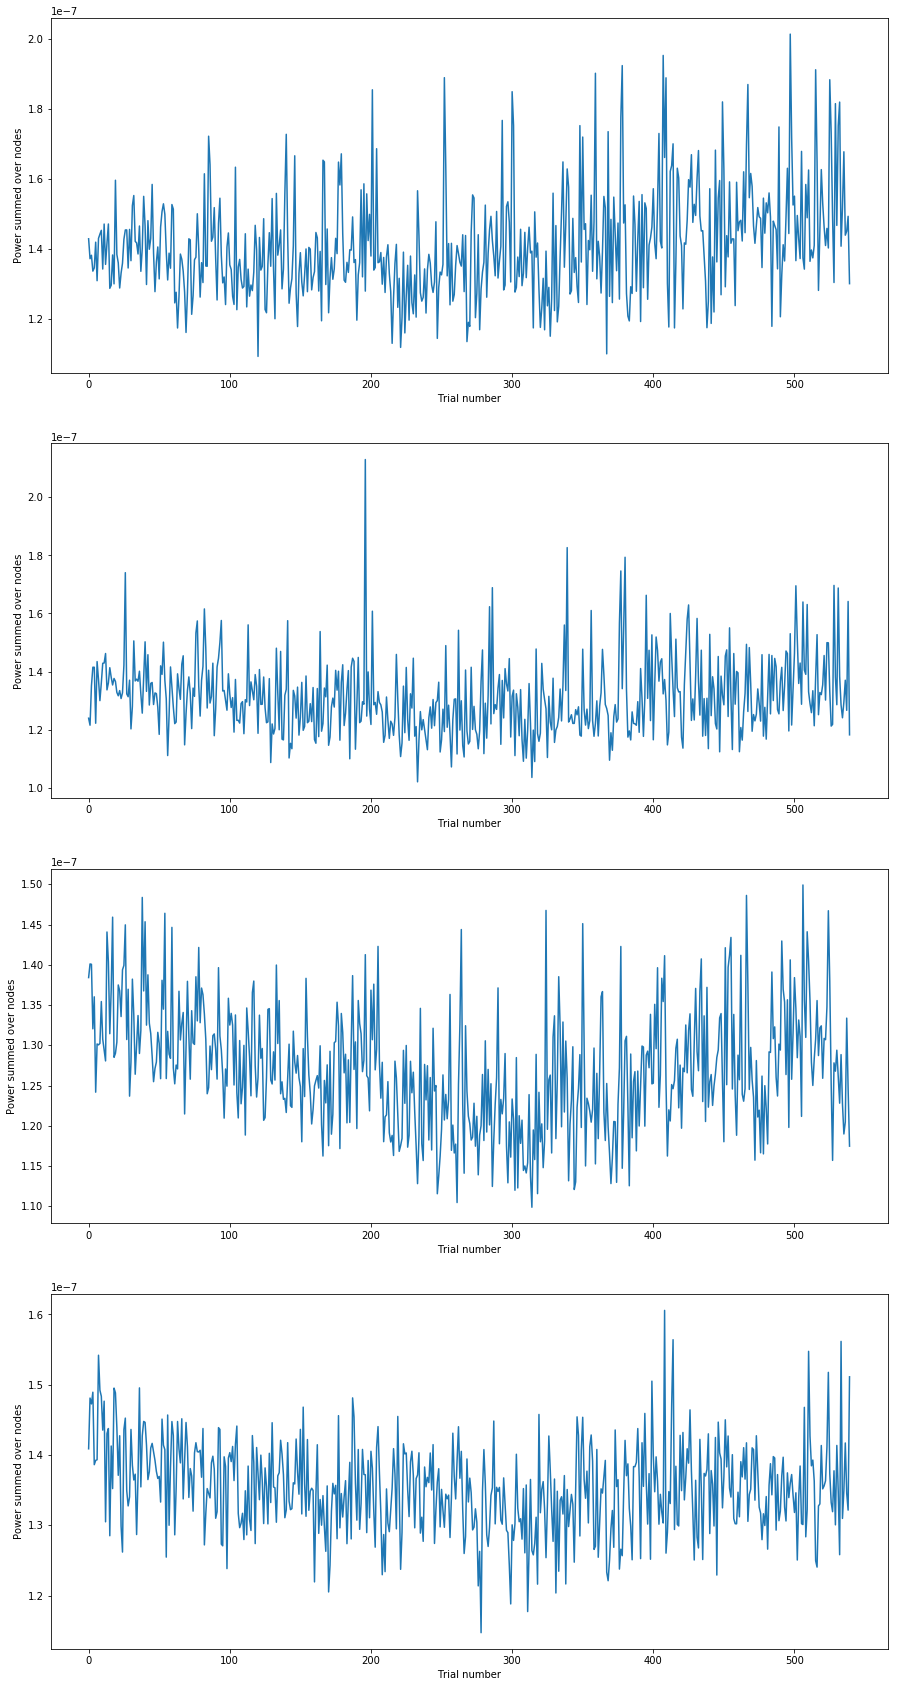

In [47]:
plt.figure(figsize=(15,30))
for i in range(len(stages)):
    plt.subplot(len(stages), 1, i+1)
    #plt.imshow(S_ps[i,:,:,0].T, aspect='auto', cmap='jet',origin='lower')
    plt.plot(S_ps[i,:,:,3].sum(axis=1))
    plt.xlabel('Trial number')
    plt.ylabel('Power summed over nodes')

In [93]:
P_mu  = np.zeros([ses.readinfo['nT'], len(stages), len(bands)])
P_std = np.zeros([ses.readinfo['nT'], len(stages), len(bands)])
for i in tqdm( range(S_avg.shape[0]) ):
    for j in range(len(bands)):
        for s in range(len(stages)):
            idx = t_mask[s].reshape(ses.readinfo['nT'], len(tarray))[i,:]
            P_mu[i,s,j]  = S_avg[i,:,j,idx].mean(axis=-1).sum(axis=0)
            P_std[i,s,j] = S_avg[i,:,j,idx].std(axis=-1).sum(axis=0)

100%|██████████| 540/540 [00:01<00:00, 465.93it/s]


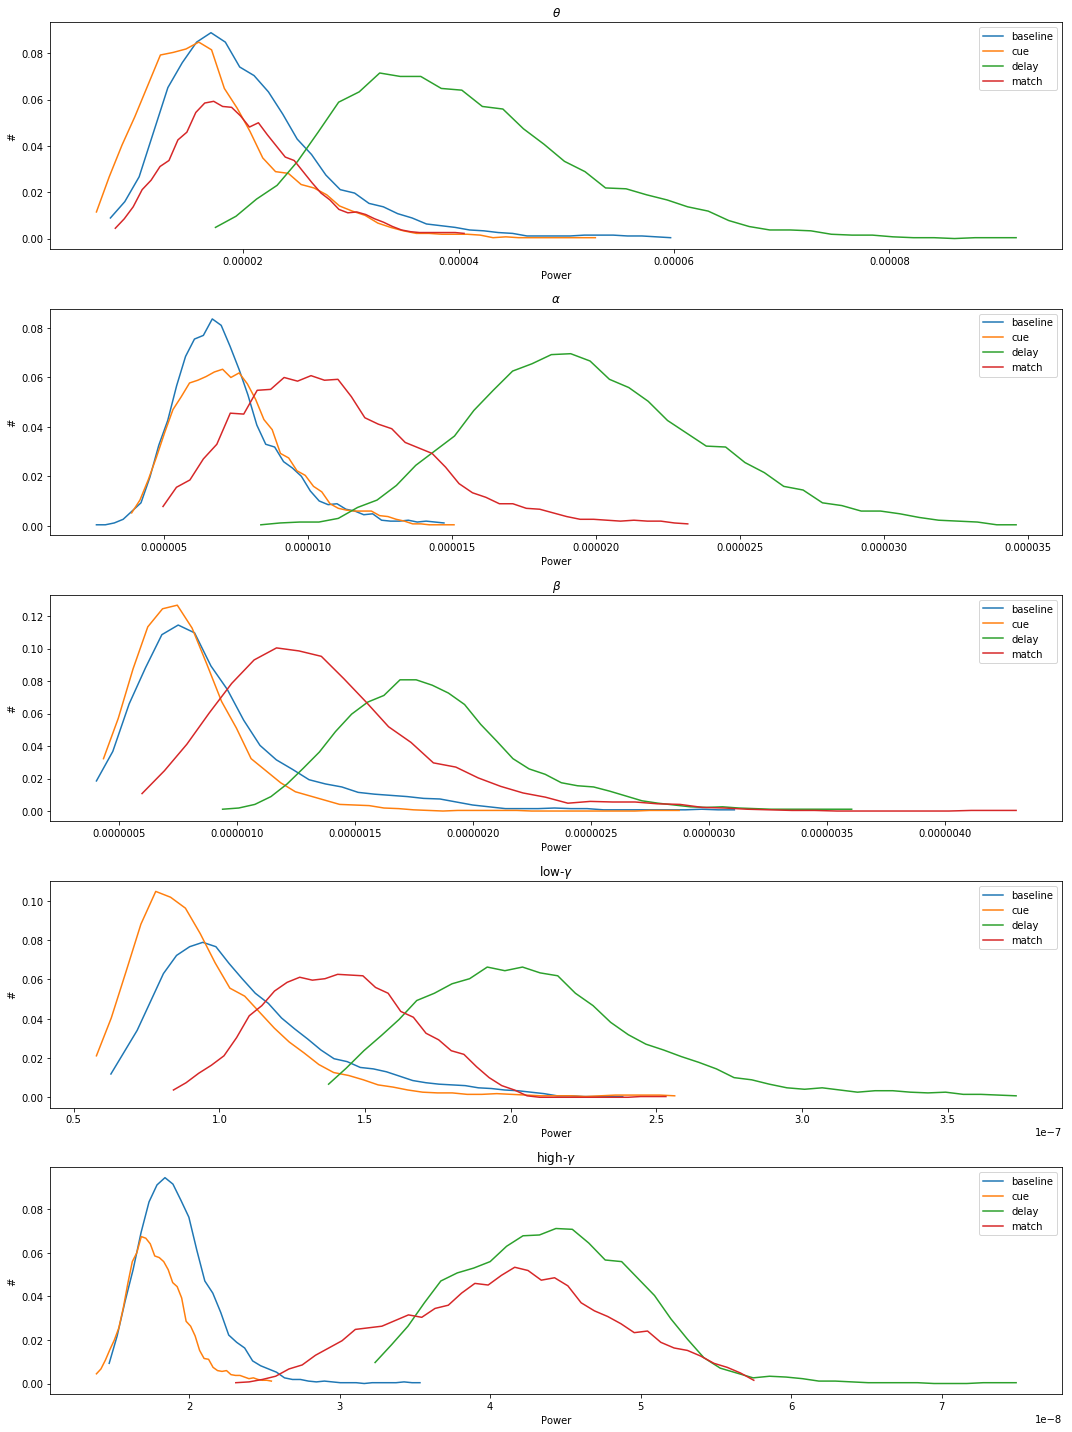

In [98]:
plt.figure(figsize=(15,20))
for j in range(len(bands)):
    plt.subplot(len(bands), 1, j+1)
    for i in range(len(stages)):
        n,x = np.histogram(P_mu[:,i,j], 40)
        n   = n/n.sum()
        plt.plot(x[1:], smooth(n, 5), label = stages[i])
    plt.legend()
    plt.title(band_names[j])
    plt.xlabel('Power')
    plt.ylabel('#')
plt.tight_layout()

In [237]:
plt.figure(figsize=(15,3))
for j in range(len(bands)):
    mu=[]
    s =[]
    for i in range(4):
        cv = S_avg[j,:,t_mask[i]].mean(axis = -1)
        mu.append(cv.mean())
        s.append(cv.std()/np.sqrt(raster.shape[1]))
    plt.subplot(1, len(bands), j+1)
    plt.errorbar(range(4), mu, s)
    plt.xticks(range(4), stages)
    plt.title(bands[j])
plt.tight_layout()

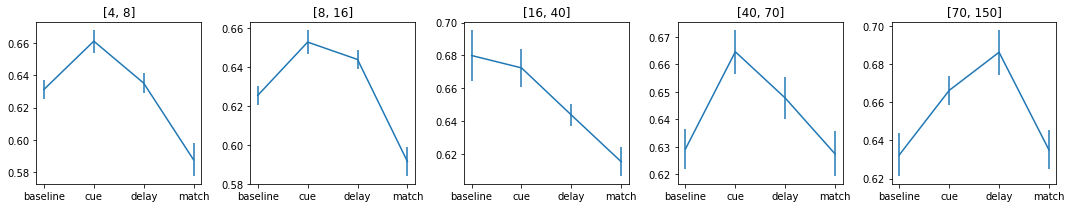

In [238]:
plt.figure(figsize=(15,3))
for j in range(len(bands)):
    mu=[]
    s =[]
    for i in range(4):
        cv = np.apply_along_axis(count_activations, 0, raster[j,:,t_mask[i]])[2,:]
        mu.append(cv.mean())
        s.append(cv.std()/np.sqrt(raster.shape[1]))
    plt.subplot(1, len(bands), j+1)
    plt.errorbar(range(4), mu, s)
    plt.xticks(range(4), stages)
    plt.title(bands[j])
plt.tight_layout()

In [239]:
nP       = int( scipy.special.comb(ses.readinfo['nC'], 2) )
# Every pair combination
i, j     = np.tril_indices(ses.readinfo['nC'], k = -1)
pairs    = np.array([j,i]).T

In [67]:
cc = np.zeros([len(stages), len(bands), ses.readinfo['nC'], ses.readinfo['nC']])
for s in tqdm( range(len(stages)) ):
    aux = raster[:,:,t_mask[s]]
    for k in range(len(bands)):
        for i, j in ses.readinfo['pairs']:
            cc[s,k,i,j] = cc[s,k,j,i] = np.corrcoef(raster[k,i,t_mask[s]], raster[k,j,t_mask[s]])[0,1]#np.dot(raster[k,i,t_mask[s]], raster[k,j,t_mask[s]]) / np.sum(t_mask[s])




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:05<00:17,  5.76s/it]


 50%|█████     | 2/4 [00:10<00:11,  5.57s/it]


 75%|███████▌  | 3/4 [00:18<00:06,  6.20s/it]


100%|██████████| 4/4 [00:22<00:00,  5.65s/it]





  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.07it/s]


 40%|████      | 2/5 [00:00<00:00,  6.34it/s]


 60%|██████    | 3/5 [00:00<00:00,  6.55it/s]


 80%|████████  | 4/5 [00:00<00:00,  6.70it/s]


100%|██████████| 5/5 [00:00<00:00,  6.99it/s]


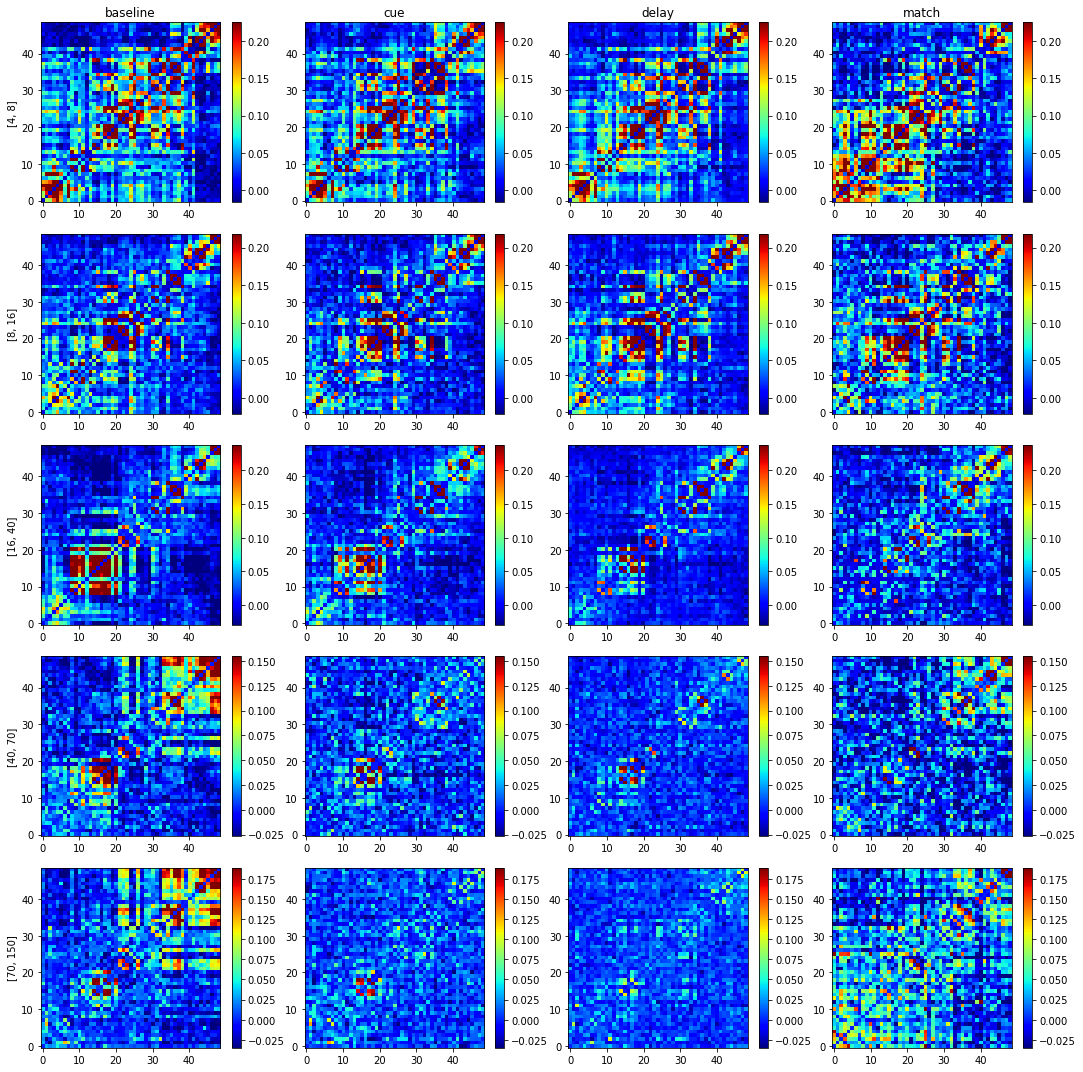

In [68]:
plt.figure(figsize=(15,15))
count = 1
for k in tqdm( range(len(bands)) ):
    for s in range(len(stages)):
            plt.subplot(len(bands), len(stages), count)
            plt.imshow(cc[s,k],aspect='auto',cmap='jet',origin='lower', vmin=cc[:,k].min()/3, vmax=cc[:,k].max()/3)
            plt.colorbar()
            if k == 0: plt.title(stages[s])
            if s == 0: plt.ylabel(bands[k])
            count+=1
plt.tight_layout()

In [242]:
cc.max()

0.7127851841793607

In [243]:
raster.shape

(5, 49, 95580)

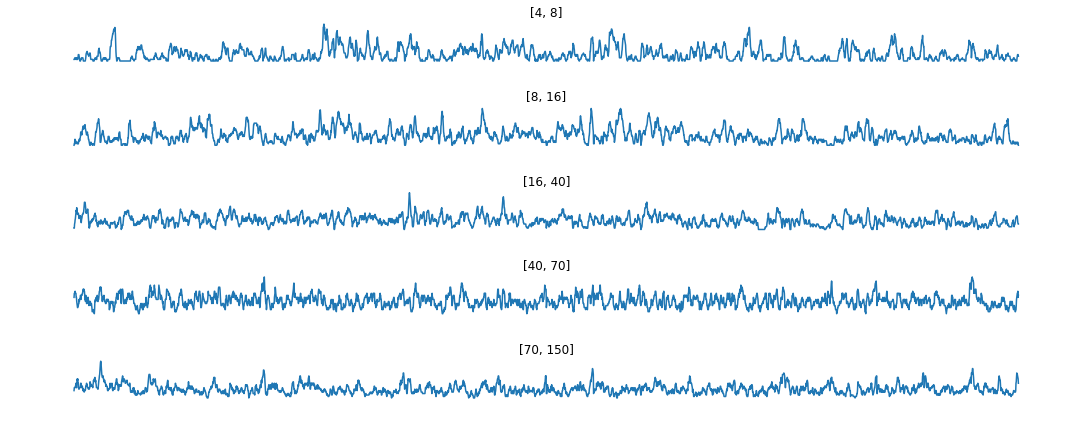

In [244]:
plt.figure(figsize=(15,6))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    rate = raster[i,:,:].sum(axis = 0)
    plt.plot(rate[:20*len(tarray)])
    plt.axis('off')
    plt.title(bands[i])
plt.tight_layout()

In [250]:
raster.shape

(5, 49, 95580)

In [246]:
rate = raster.sum(axis=1)

In [253]:
rate = raster.reshape(5,49,540,len(tarray))

In [254]:
rate.shape

(5, 49, 540, 177)

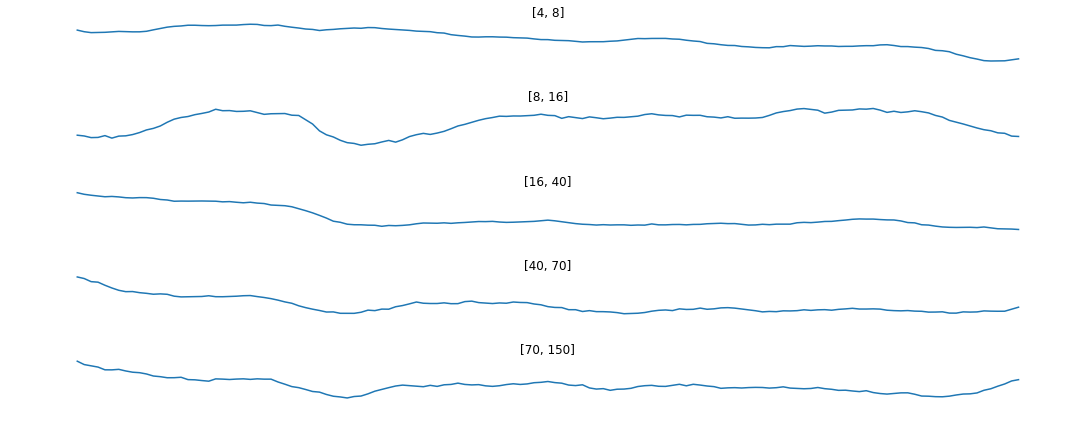

In [249]:
plt.figure(figsize=(15,6))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.plot(rate[i,:,20:-20].mean(axis=0))
    plt.axis('off')
    plt.title(bands[i])
plt.tight_layout()

In [258]:
tt = np.tile(tarray, ses.readinfo['nT'])

In [261]:
raster.shape

(5, 49, 95580)

In [263]:
cv

[1677.7600029092198,
 5050.105380211031,
 -3426.735066491859,
 1172.61389054276,
 1885.2697038764315,
 -3363.5898672880444,
 -4901.733354896462,
 10304.4364874662,
 1864.0973110818272,
 1623.095415744339,
 1742.107673796441,
 2007.3273942565784,
 4288.229615213731,
 4105.394875979137,
 3041.7292392552818,
 -9867.194919671154,
 8908.061031127765,
 10347.321875730666,
 2068.1790526747413,
 12353.325105429712,
 3880.1477557845724,
 4.404578500375558e+16,
 3864.1376635724873,
 1552.943439719278,
 10379.474603136472,
 2446.093679520111,
 2716.654692706038,
 2079.7734355064117,
 2954.7361954271228,
 21512.15202298069,
 11145.291790186473,
 -3704.332621180665,
 1778.5246801352614,
 5794.283053795024,
 -102222.98071382116,
 1884.8348732614036,
 1680.1784367377368,
 1720.538299589659,
 4467.226165846585,
 6379.084019188702,
 -4641.021380471617,
 2447.7642215315973,
 2576.802280078299,
 2253.714876037299,
 2201.2991956207134,
 2351.4117708774784,
 5019.7412242407945,
 3033.793778595067,
 1856.56

In [264]:
t_spike.shape

(9558,)

In [273]:
bounded = [1,0,1,0,0,0,1,1,1]

In [277]:
    difs    = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends,   = np.where(difs < 0)

In [278]:
run_starts

array([2, 7])

In [279]:
run_ends

array([1, 5])

In [280]:
difs    = np.diff(bounded)

In [283]:
raster.shape

(5, 49, 95580)

In [282]:
from sklearn.manifold import TSNE

In [293]:
Y = TSNE(n_components=2, metric='hamming', perplexity=15.0).fit_transform(raster[1,:,:30*len(tarray)].T) 

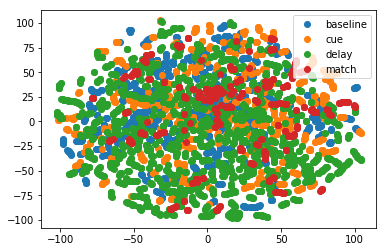

In [294]:
for i in range(len(stages)):
    plt.plot(Y[t_mask[i][:30*len(tarray)],0], Y[t_mask[i][:30*len(tarray)],1], 'o', label = stages[i])
plt.legend()

In [38]:
S = S_avg.reshape(5,49,540,len(tarray))

In [59]:
PLV = np.zeros([540,49,49])
for T in tqdm( range(ses.readinfo['nT']) ):
    for i, j in ses.readinfo['pairs']:
        PLV[T,i,j]=PLV[T,j,i]=phase_locking_value(S[2,i,T,:], S[2,j,T,:])

100%|██████████| 540/540 [02:53<00:00,  3.11it/s]


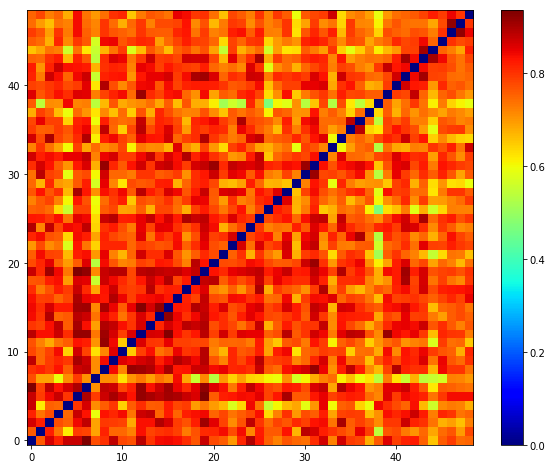

In [62]:
plt.figure(figsize=(10,8))
plt.imshow(PLV[10], aspect='auto', cmap='jet',origin='lower')
plt.colorbar()

In [48]:
ses.readinfo['pairs']

array([[ 0,  1],
       [ 0,  2],
       [ 1,  2],
       ...,
       [45, 48],
       [46, 48],
       [47, 48]])

In [82]:
t_mask[s].reshape(ses.readinfo['nT'], len(tarray)).shape

(540, 214)

In [45]:
ses.readinfo['stim'].shape

(540,)